# <center>Restricted Boltzmann Machines</center>

<h3>Introduction</h3>

Restricted Boltzmann Machine RBMs are flat neural networks that learn to reconstruct data independently by themselves in an unsupervised fashion. It can automatically extract meaningful features by constructing and deconstructing from a given input.

<h4>How does it work?</h4>

RBM is a two-layer neural network. Simply put, RBM takes the input and translates it into a set of binary values representing it in the hidden layer. These numbers can then be retranslated to reconstruct the inputs. Multiple forward and backward passes train the RBM, and a trained RBM can reveal which features are most important in pattern recognition.   

<center><img src="./img/1.PNG" alt="RBM Model" style="width: 400px;"></center>

 The RBM is useful for:
 
    1. Collaborative Filtering
    2. Dimensionality reduction
    3. Classification
    3. Regression
    4. Feature learning
    5. Topic modeling 
    6. Deep Belief Networks



<h4>Is RBM a generative or Discriminative model?</h4>
RBM is a generative model. first,see what is different between discriminative and generative models: 

<b>Discriminative:</b> Consider a classification problem in which we want to learn to distinguish between Sedan cars (y = 1) and SUV cars (y = 0), based on some features of cars. Given a training set, an algorithm like logistic regression tries to find a straight line—that is, a decision boundary like below—that separates the suv and sedan.

<center><img src="./img/2.PNG" alt=" a decision boundar" style="width: 400px;"></center>


<b>Generative:</b> looking at cars, we can build a model of what Sedan cars look like. Then, looking at SUVs, we can build a separate model of what SUV cars look like. Finally, to classify a new car, we can match the new car against the Sedan model, and match it against the SUV model, to see whether the new car looks more like the SUV or Sedan. 

Generative Models specify a probability distribution over a dataset of input vectors. We can do both supervise and unsupervised tasks with generative models:
<ul>
    <li>In an unsupervised task, we try to form a model for P(x), where P is the probability given x as an input vector.</li>
    <li>In the supervised task, we first form a model for P(x|y), where P is the probability of x given y(the label for x). For example, if y = 0 indicates whether a car is a SUV or y = 1 indicates a car is a Sedan, then p(x|y = 0) models the distribution of SUVs’ features, and p(x|y = 1) models the distribution of Sedans’ features. If we manage to find P(x|y) and P(y), then we can use <code>Bayes rule</code> to estimate P(y|x), because: $$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$</li>
</ul>
**Now the question is, can we build a generative model, and then use it to create synthetic data by directly sampling from the modeled probability distributions? Lets see. **


<a id="ref1"></a>
<h3>Initialization</h3>

First we have to load the utility file which contains different utility functions that are not connected
in any way to the networks presented in the tutorials, but rather help in
processing the outputs into a more understandable way.

In [545]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

Now, we load in all the packages that we use to create the net including the TensorFlow package:

In [546]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
import pickle
import random as rnd

%matplotlib inline

<a id="ref2"></a>
<h3>Example of RBM layers</h3>

An RBM has two layers. The first layer of the RBM is called the visible or input layer. Imagine that the toy example, has only vectors with 7 values, so the visible layer must have j=7 input nodes. 
The second layer is the <b>hidden</b> layer, which possesses i neurons in our case. Each hidden node can have either 0 or 1 values (i.e., si = 1 or si = 0) with a probability that is a logistic function of the inputs it receives from the other j visible units, called for example, p(si = 1). For our toy sample, we'll use 2 nodes in the hidden layer, so i = 2.

<center><img src="https://ibm.box.com/shared/static/eu26opvcefgls6vnwuo29uwp0nudmokh.png" alt="RBM Model" style="width: 400px;"></center>

     

Each node in the first layer also has a <b>bias</b>. We will denote the bias as “v_bias” for the visible units. The <b>v_bias</b> is shared among all visible units.

Here we define the <b>bias</b> of second layer as well. We will denote the bias as “h_bias” for the hidden units. The <b>h_bias</b> is shared among all hidden units

In [47]:
v_bias = tf.placeholder("float", [7])
h_bias = tf.placeholder("float", [2])

We have to define weights among the input layer and hidden layer nodes. In the weight matrix, the number of rows are equal to the input nodes, and the number of columns are equal to the output nodes. Let <b>W</b> be the Tensor of 7x2 (7 - number of visible neurons, 2 - number of hidden neurons) that represents weights between neurons. 

In [48]:
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

<a id="ref3"></a>
<h3>What RBM can do after training?</h3>
Think RBM as a model that has been trained based on images of a dataset of many SUV and Sedan cars. Also, imagine that the RBM network has only two hidden nodes, one for the weight and, and one for the size of cars, which in a sense, their different configurations represent different cars, one represent SUV cars and one for Sedan. In a training process, through many forward and backward passes, RBM adjust its weights to send a stronger signal to either the SUV node (0, 1) or the Sedan node (1, 0) in the hidden layer, given the pixels of images. Now, given a SUV in hidden layer, which distribution of pixels should we expect? RBM can give you 2 things. First, it encodes your images in hidden layer. Second, it gives you the probability of observing a case, given some hidden values.


<h3>How to inference?</h3>

RBM has two phases:
<ul>
    <li>Forward Pass</li>  
    <li>Backward Pass or Reconstruction</li>
</ul>

<h5>Phase 1) Forward pass:</h5>

Input one training sample (one image) <b>X</b> through all visible nodes, and pass it to all hidden nodes. Processing happens in each node in the hidden layer. This computation begins by making stochastic decisions about whether to transmit that input or not (i.e. to determine the state of each hidden layer). At the hidden layer's nodes, <b>X</b> is multiplied by a <b>$W_{ij}$</b> and added to <b>h_bias</b>. The result of those two operations is fed into the sigmoid function, which produces the node’s output, $p({h_j})$, where j is the unit number. 


<center>$p({h_j})= \sigma(\sum_i w_{ij} x_i)$, where $\sigma()$ is the logistic function.</center>


Now lets see what $p({h_j})$ represents. In fact, it is the probabilities of the hidden units. And, all values together are called <b>probability distribution</b>. That is, RBM uses inputs x to make predictions about hidden node activations. For example, imagine that the values of $h_p$ for the first training item is [0.51 0.84]. It tells you what is the conditional probability for each hidden neuron to be at Phase 1): 
<ul>
    <li>p($h_{1}$ = 1|V) = 0.51</li>
    <li>p($h_{2}$ = 1|V) = 0.84</li>  
</ul>

As a result, for each row in the training set, <b>a vector/tensor</b> is generated, which in our case it is of size [1x2], and totally n vectors ($p({h})$=[nx2]). 

We then turn unit $h_j$ on with probability $p(h_{j}|V)$, and turn it off with probability $1 - p(h_{j}|V)$.

Therefore, the conditional probability of a configuration of h given v (for a training sample) is:

$$p(\mathbf{h} \mid \mathbf{v}) = \prod_{j=0}^H p(h_j \mid \mathbf{v})$$

In [49]:
sess = tf.Session()
X = tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])
v_state = X
print ("Input: ", sess.run(v_state))
print()

h_bias = tf.constant([0.1, 0.1])
print ("hb: ", sess.run(h_bias))
print()
print ("w: ", sess.run(W))
print()

# Calculate the probabilities of turning the hidden units on:
h_prob = tf.nn.sigmoid(tf.matmul(v_state, W) + h_bias)  #probabilities of the hidden units
print ("p(h|v): ", sess.run(h_prob))
print()


Input:  [[1. 0. 0. 1. 0. 0. 0.]]

hb:  [0.1 0.1]

w:  [[ 1.8679434  -0.44027936]
 [ 0.37655714 -0.17538284]
 [ 1.8206167   0.11964226]
 [ 0.20984906  0.99606174]
 [ 0.8250144  -0.648984  ]
 [ 0.22058232 -0.36981645]
 [-0.6893367   0.37502274]]

p(h|v):  [[0.89823747 0.6583123 ]]



Then, we take the tensor of probabilities (as from a sigmoidal activation-->h_prob) and make samples from all the distributions,  That is, we sample the activation vector from the probability distribution of hidden layer values.

In [88]:
# Draw samples from the distribution  
    
print ('h_prob:                                   ',sess.run(h_prob))
b=sess.run(tf.random_uniform(tf.shape(h_prob)))
print ('random_uniform:                           ',b)
print ('h_prob substracted the random uniform:    ',sess.run(h_prob-b))
print ('tf.sign:                                  ',sess.run(tf.sign( h_prob - b)))
h_state=sess.run(tf.nn.relu(tf.sign( h_prob- b)))
print ('samples from all the h_prob distributions:',h_state)

h_prob:                                    [[0.89823747 0.6583123 ]]
random_uniform:                            [[0.62753356 0.8048754 ]]
h_prob substracted the random uniform:     [[ 0.2707039  -0.14656305]]
tf.sign:                                   [[ 1. -1.]]
samples from all the h_prob distributions: [[1. 0.]]


<b>Phase 2) Backward Pass (Reconstruction):</b>
The RBM reconstructs data by making several forward and backward passes between the visible and hidden layers.

So, in the second phase (i.e. reconstruction phase), the samples from the hidden layer (i.e. h) play the role of input. That is, <b>h</b> becomes the input in the backward pass. The same weight matrix and visible layer biases are used to go through the sigmoid function. The produced output is a reconstruction which is an approximation of the original input.

In [51]:
print ("X:                         ", sess.run(X))

print('h_state:                   ',h_state)

vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1])
print ("biases:                    ", sess.run(vb))

v_prob = tf.nn.sigmoid(tf.matmul(h_state, tf.transpose(W)) + vb) 
print ("p(vi∣h):                   ",  sess.run(v_prob))

v_state = tf.nn.relu(tf.sign(v_prob - tf.random_uniform(tf.shape(v_prob)))) #sample_v_given_h
print ("v probability states:      ", sess.run(v_state))



X:                          [[1. 0. 0. 1. 0. 0. 0.]]
h_state:                    [[0. 1.]]
biases:                     [0.1 0.2 0.1 0.1 0.1 0.2 0.1]
p(vi∣h):                    [[0.41574162 0.50615394 0.5546909  0.74952143 0.36610016 0.45764765
  0.61657184]]
v probability states:       [[0. 0. 0. 0. 0. 0. 0.]]


RBM learns a probability distribution over the input, and then, after being trained, the RBM can generate new samples from the learned probability distribution. As you know, <b>probability distribution</b>, is a mathematical function that provides the probabilities of occurrence of different possible outcomes in an experiment.

The (conditional) probability distribution over the visible units v is given by
<center>
$p(\mathbf{v} \mid \mathbf{h}) = \prod_{i=0}^V p(v_i \mid \mathbf{h}),$
</center>

<center>
where,
</center>


<center>

$p(v_i \mid \mathbf{h}) = \sigma\left( a_i + \sum_{j=0}^H w_{ji} h_j \right)$
</center>

so, given current state of hidden units and weights, what is the probability of generating [1. 0. 0. 1. 0. 0. 0.] in reconstruction phase, based on the above <b>probability distribution</b> function?

In [52]:
inp = sess.run(X)
print(inp)
v_prob=sess.run(v_prob)
print(v_prob[0])
v_probability = 1
for elm, p in zip(inp[0],v_prob[0]) :
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)
v_probability

[[1. 0. 0. 1. 0. 0. 0.]]
[0.41574162 0.50615394 0.5546909  0.74952143 0.36610016 0.45764765
 0.61657184]


0.009033309608215342

How similar X and V vectors are? Of course, the reconstructed values most likely will not look anything like the input vector because our network has not trained yet. Our objective is to train the model in such a way that the input vector and reconstructed vector to be same. Therefore, based on how different the input values look to the ones that we just reconstructed, the weights are adjusted. 

<hr>

<h3> German Traffic Sign Dataset</h3>
you can download the pickled data of the German Traffic Sign Dataset [Here](https://github.com/A2Amir/Traffic_Sign_Classifier/tree/master/data)

We will be using the German Traffic Sign Dataset  to practice the usage of RBMs. The following cell loads the  German Traffic Sign dataset.

In [475]:
# Load pickled data

# Fill this in based on where you saved the training and testing and validation data

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file,mode='rb') as f:
    train=pickle.load(f)
with open(validation_file,mode='rb') as f:
    valid=pickle.load(f)
with open(testing_file,mode='rb') as f:
    test=pickle.load(f)
x_train,y_train=train['features'],train['labels']
x_valid,y_valid=valid['features'],valid['labels']
x_test,y_test=test['features'],test['labels']

#assert weathers the number of training images and labels are equal
assert(len(x_train)==len(y_train))
assert(len(x_valid)==len(y_valid))
assert(len(x_test)==len(y_test))

In [476]:
print()
print('Image shape{}'.format(x_train[0].shape))
print('Trainini set {} samples'.format(len(x_train)))
print('Validation set {} samples'.format(len(x_valid)))
print('Test set {} samples'.format(len(x_test)))


Image shape(32, 32, 3)
Trainini set 34799 samples
Validation set 4410 samples
Test set 12630 samples


Below is shown some images from the dataset:


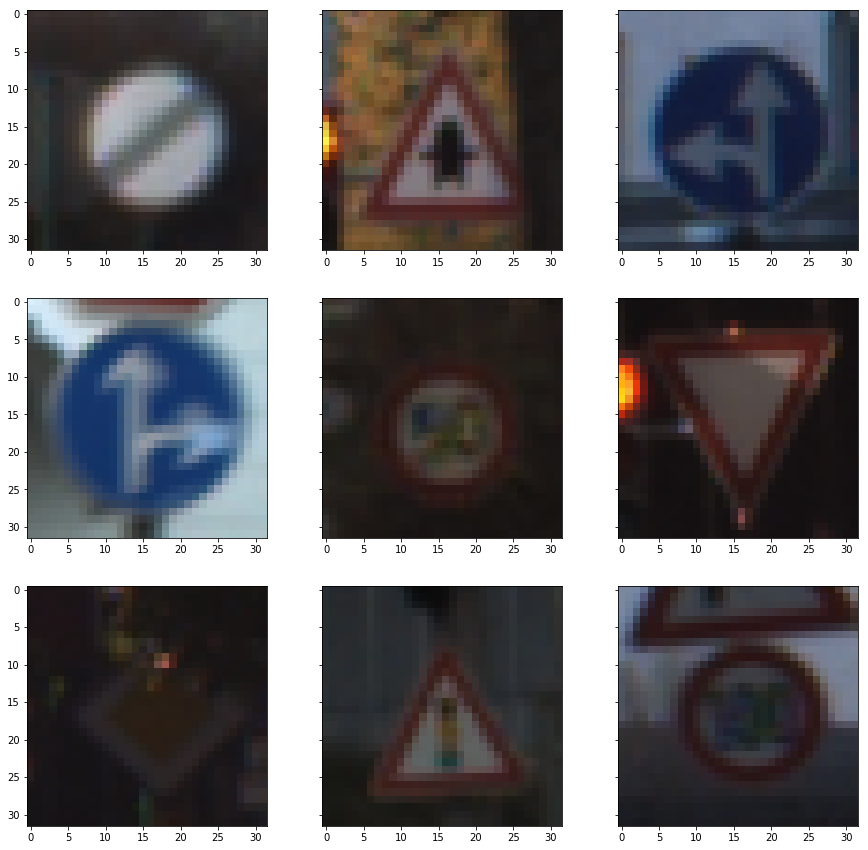

In [477]:

rows = 3
cols = 3
fig, axis = plt.subplots(rows,cols,sharey=True)
fig.set_size_inches(15,15)
for i in range(rows*cols):
    index=rnd.randint(0,len(x_train))
    img=x_train[index]
    axis[int(i/rows)][i%cols].imshow(img)



### Normalize Pixel Values

In [478]:
# convert from integers to floats
x_train = x_train.astype('float32')
# normalize to the range 0-1
x_train /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (x_train.min(), x_train.max()))

Min: 0.000, Max: 1.000


### Center Pixel Values: Global Centering

In [479]:
mean = x_train.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (x_train.min(), x_train.max()))
# global centering of pixels
x_train = x_train - mean
# confirm it had the desired effect
mean = x_train.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (x_train.min(), x_train.max()))

Mean: 0.324
Min: 0.000, Max: 1.000
Mean: -0.000
Min: -0.324, Max: 0.676


### Center Pixel Values:Local Centering

In [480]:
means = x_train.mean(axis=(0,1), dtype='float32')
#print('Means: %s' % means)
#print('Mins: %s, Maxs: %s' % (x_train.min(axis=(0,1)), x_train.max(axis=(0,1))))
# per-channel centering of pixels
x_train -= means
# confirm it had the desired effect
means = x_train.mean(axis=(0,1), dtype='float32')
#print('Means: %s' % means)
#print('Mins: %s, Maxs: %s' % (x_train.min(axis=(0,1)), x_train.max(axis=(0,1))))

### Standardize Pixel Values:Global Standardization

In [481]:
# calculate global mean and standard deviation
mean, std = x_train.mean(), x_train.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
x_train = (x_train - mean) / std
# confirm it had the desired effect
mean, std = x_train.mean(), x_train.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

Mean: 0.000, Standard Deviation: 0.265
Mean: -0.000, Standard Deviation: 1.000


In [482]:
x_train.shape

(34799, 32, 32, 3)

wir are going to convert all RGB images into gray scal images.

In [483]:
x_train=x_train[:,:,:,0]

In [484]:
x_train.shape

(34799, 32, 32)

Each image of the German Traffic Sign dataset has 3072 pixels, so the visible layer must have 1024 input nodes.  For our case, we'll use 512 nodes in the hidden layer, so i = 512.

In [485]:
x_train.shape

(34799, 32, 32)

In [486]:
x_train=np.reshape(x_train,(x_train.shape[0],32*32))

In [487]:
print(x_train[0].shape)


(1024,)


In [488]:
#number of visible neurons
NoVN=1024
#number of hidden neurons
NoHN=780

In [489]:
v0_state = tf.placeholder("float", [None, NoVN])
vb = tf.placeholder("float", [NoVN])
hb = tf.placeholder("float", [NoHN])

Let <b>W</b> be the Tensor of 1024x 512 (1024 - number of visible neurons (32, 32), 780 - number of hidden neurons) that represents weights between the neurons. 

In [490]:
W = tf.placeholder("float", [NoVN, NoHN])

Now, we can define hidden layer:

In [491]:
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + hb)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

Now, we define reconstruction part:

In [492]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

<h3>What is objective function?</h3>

<b>Goal</b>: Maximize the likelihood of our data being drawn from that distribution

<b>Calculate error:</b>  
In each epoch, we compute the "error" as a sum of the squared difference between step 1 and step n,
e.g the error shows the difference between the data and its reconstruction.

<b>Note:</b> tf.reduce_mean computes the mean of elements across dimensions of a tensor.

In [493]:
err = tf.reduce_mean(tf.square(v0_state - v1_state))

<a id="ref4"></a>
<h3>How to train the model?</h3>

The following part discuss how to train the model which needs some algebra background. Still, you can skip this part and run the next cells.

As already mentioned, we want to give a high probability to the input data on which we train. So, in order to train an RBM, we have to maximize the product of probabilities assigned to all rows v (images) in the training set V (a matrix, where each row of it is treated as a visible vector v):

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a">


Which is equivalent, maximizing the expected log probability of V:


<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ba0ceed99dca5ff1d21e5ace23f5f2223f19efc0">


So, we have to update the weights wij  to increase p(v) for all v in our training data during training. So we have to calculate the derivative:


$$\frac{\partial \log p(\mathbf v)}{\partial w_{ij}}$$

This cannot be easily done by typical <b>gradient descent (SGD)</b>, so we can use another approach, which has 2 steps:
<ol>
    <li>Gibbs Sampling</li>
    <li>Contrastive Divergence</li>
</ol>    
    
<h3>Gibbs Sampling</h3>   
First, given an input vector v we are using p(h|v) for prediction of the hidden values h. 
<ul>
    <li>$p(h|v) = sigmoid(X \otimes W + hb)$</li>
    <li>h0 = sampleProb(h0)</li>
</ul>
    
Then, knowing the hidden values, we use p(v|h) for reconstructing of new input values v. 
<ul>
    <li>$p(v|h) = sigmoid(h0 \otimes transpose(W) + vb)$</li>
    <li>$v1 = sampleProb(v1)$  (Sample v given h)</li>
</ul>
        
This process is repeated k times. After k iterations we obtain an other input vector vk which was recreated from original input values v0 or X.

Reconstruction steps:
<ul>
    <li> Get one data point from data set, like <i>x</i>, and pass it through the net</li>
    <li>Pass 0: (x)  $\Rightarrow$ (h0) $\Rightarrow$  (v1)   (v1 is reconstruction of the first pass)</li>
    <li>Pass 1: (v1) $\Rightarrow$  (h1) $\Rightarrow$  (v2)   (v2 is reconstruction of the second pass)</li>
    <li>Pass 2: (v2) $\Rightarrow$  (h2) $\Rightarrow$  (v3)   (v3 is reconstruction of the third pass)</li>
    <li>Pass n: (vk) $\Rightarrow$  (hk+1) $\Rightarrow$  (vk+1)(vk is reconstruction of the nth pass)</li>
</ul>
        
<h4>What is sampling here (sampleProb)?</h4>

In forward pass: We randomly set the values of each hi to be 1 with probability $sigmoid(v \otimes W + hb)$.  
- To sample h given v means to sample from the conditional probability distribution P(h|v). It means that you are asking what are the probabilities of getting a specific set of values for the hidden neurons, given the values v for the visible neurons, and sampling from this probability distribution. 
In reconstruction: We randomly set the values of each vi to be 1 with probability $ sigmoid(h \otimes transpose(W) + vb)$.

<h3>contrastive divergence (CD-k)</h3>
The update of the weight matrix is done during the Contrastive Divergence step. 

Vectors v0 and vk are used to calculate the activation probabilities for hidden values h0 and hk. The difference between the outer products of those probabilities with input vectors v0 and vk results in the update matrix:


$\Delta W =v0 \otimes h0 - vk \otimes hk$ 

Contrastive Divergence is actually matrix of values that is computed and used to adjust values of the W matrix. Changing W incrementally leads to training of W values. Then on each step (epoch), W is updated to a new value W' through the equation below:

$W' = W + alpha * \Delta W$ 

 
<b>What is Alpha?</b>  
Here, alpha is some small step rate and is also known as the "learning rate".




Ok, lets assume that k=1, that is we just get one more step:

In [532]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) #sample_h_given_X

In [533]:
alpha = .0001
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

In [534]:
initializer = tf.contrib.layers.xavier_initializer(uniform=True,seed=None, dtype=tf.float32)

Let's start a session and initialize the variables:

In [535]:
sess = tf.InteractiveSession()

cur_w = initializer([NoVN, NoHN], tf.float32).eval()

cur_vb = initializer([NoVN], tf.float32).eval()
cur_hb = initializer([NoHN], tf.float32).eval()
prv_w = initializer([NoVN, NoHN], tf.float32).eval()
prv_vb = initializer([NoVN], tf.float32).eval()
prv_hb = initializer([NoHN], tf.float32).eval()


sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Lets look at the error of the first run:

In [536]:
sess.run(err, feed_dict={v0_state: x_train, W: prv_w, vb: prv_vb, hb: prv_hb})

1.4540901

In [537]:
x_train.shape

(34799, 1024)

Epoch: 0 reconstruction error: 0.929756
Epoch: 1 reconstruction error: 0.925048
Epoch: 2 reconstruction error: 0.930670
Epoch: 3 reconstruction error: 0.933905
Epoch: 4 reconstruction error: 0.936051
Epoch: 5 reconstruction error: 0.937396
Epoch: 6 reconstruction error: 0.938633
Epoch: 7 reconstruction error: 0.939662
Epoch: 8 reconstruction error: 0.940262
Epoch: 9 reconstruction error: 0.940698
Epoch: 10 reconstruction error: 0.941338
Epoch: 11 reconstruction error: 0.941500
Epoch: 12 reconstruction error: 0.942069
Epoch: 13 reconstruction error: 0.942426
Epoch: 14 reconstruction error: 0.942692


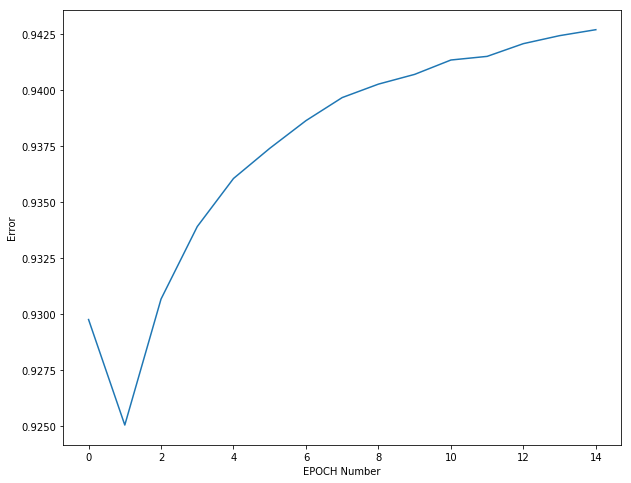

In [538]:
#Parameters
epochs = 15
batchsize = 4096
weights = []
errors = []
for epoch in range(epochs):
    for start, end in zip( range(0, len(x_valid), batchsize), range(batchsize, len(x_valid), batchsize)):
        #print(start, end )
        batch = x_train[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ v0_state: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={v0_state: x_train, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1])
plt.figure(figsize=((10,8)))
plt.plot(errors)
plt.xlabel("EPOCH Number")
plt.ylabel("Error")
plt.show()

What is the final weight after training?

In [540]:
uw = weights[-1].T
print (uw.shape) # a weight matrix of shape (1024,780)

(780, 1024)


<a id="ref5"></a>
<h3>Learned features</h3> 

We can take each hidden unit and visualize the connections between that hidden unit and each element in the input vector. In our case, we have 780 hidden units. Lets visualize those.

Let's plot the current weights:
<b>tile_raster_images</b> helps in generating an easy to grasp image from a set of samples or weights. It transform the <b>uw</b> (with one flattened image per row of size 1024), into an array (of size $32\times32$) in which images are reshaped and laid out like tiles on a floor.

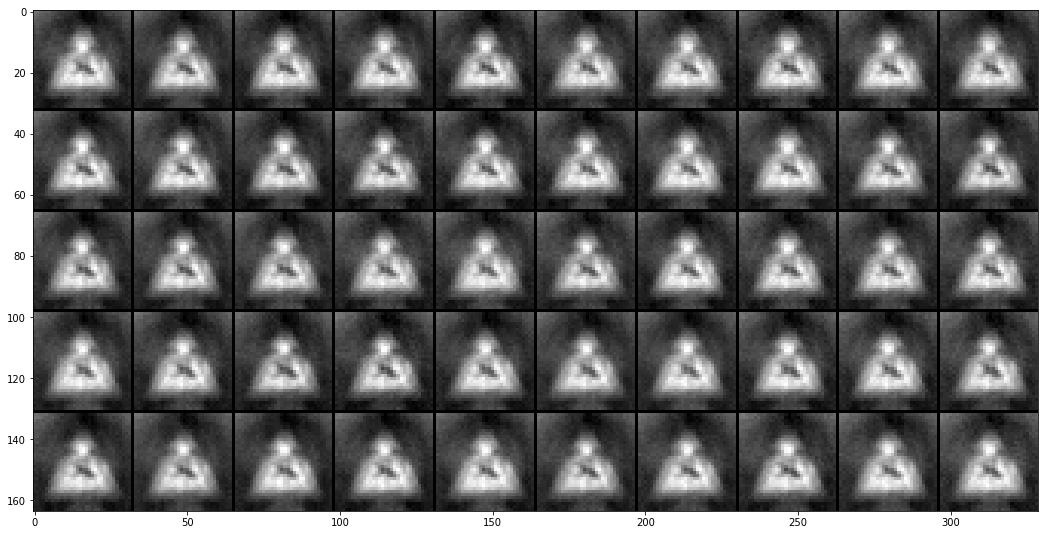

In [541]:
tile_raster_images(X=cur_w.T, img_shape=(32, 32), tile_shape=(5, 10), tile_spacing=(1, 1))
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(32, 32) ,tile_shape=(5, 10), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

In [542]:
cur_w.shape

(1024, 780)

Each tile in the above visualization corresponds to a vector of connections between a hidden unit and visible layer's units. 

Let's look at one of the learned weights corresponding to one of hidden units for example. In this particular square, the gray color represents weight = 0, and the whiter it is, the more positive the weights are (closer to 1). Conversely, the darker pixels are, the more negative the weights. The positive pixels will increase the probability of activation in hidden units (after multiplying by input/visible pixels), and negative pixels will decrease the probability of a unit hidden to be 1 (activated). So, why is this important?  So we can see that this specific square (hidden unit) can detect a feature (e.g. a "/" shape) and if it exists in the input.

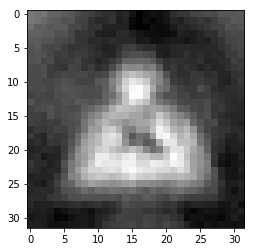

In [544]:
from PIL import Image
image = Image.fromarray(tile_raster_images(X =cur_w.T[15:16], img_shape=(32, 32),tile_shape=(1, 1), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

### References:
https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine  
http://deeplearning.net/tutorial/rbm.html  
http://www.cs.utoronto.ca/~hinton/absps/netflixICML.pdf<br>
http://imonad.com/rbm/restricted-boltzmann-machine/  
https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/

